# EEP Project 4: Tanzania



Team Members: Alyssa Suzukawa (Team Manager), Amber Chen, Joneil Manansala, Nicole Inaba, Siddharth Bamel

### Preface



Install modules and set up dataframes:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc[gdrive]
!pip install h5netcdf
import pandas as pd
import matplotlib.pyplot as plt

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.9)


In [2]:
!gpg -d --batch --passphrase "noodle octopus" ../students.json.gpg > ../students.json

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


In [3]:
COUNTRY = 'Tanzania'

In [4]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/',
       'Tanzania':'https://docs.google.com/spreadsheets/d/1Tknc2F8K6SaA7j0R7J_NE8yJBTsCPPw77_Bfc04MY40/',
       'ICRISAT':'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo'}
DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'ICRISAT':365.25} # Number of days of expenditure recall

In [5]:
from eep153_tools import read_sheets

my_creds = '../students.json'

### Estimation



First, we pull in data and estimate CFE demands *given* the prices
    and budgets of households in the data.



In [6]:
import cfe
import numpy as np
from eep153_tools import read_sheets

x = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Expenditures').set_index(['j','t','m'])
x.columns.name = 'i'
x = x.replace(0,np.nan)
y = np.log(x)

z = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='HH Characteristics').set_index(['j','t','m'])
z.columns.name = 'k'

p = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Prices').set_index(['t','m'])
p.columns.name = 'i'

r = cfe.Result(y=y,z=z,prices=p)

r.get_alpha()
xhat = r.get_predicted_expenditures()

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Save estimation results:


In [7]:
r.to_dataset("my %s.ds" % COUNTRY)

/opt/conda/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


<xarray.Dataset>
Dimensions:           (i: 61, j: 12424, k: 15, kp: 15, m: 1, t: 4)
Coordinates:
  * j                 (j) object '0001-001' '0001-004' ... '905012325008102'
  * i                 (i) object 'Beef' 'Bottled beer' ... 'Yams/cocoyams'
  * k                 (k) object 'F 00-03' 'M 00-03' ... 'M 51+' 'log HSize'
  * t                 (t) object '2008-09' '2010-11' '2012-13' '2014-15'
  * m                 (m) object 'Tanzania'
  * kp                (kp) <U9 'F 00-03' 'F 04-08' ... 'M 51+' 'log HSize'
Data variables:
    alpha             (i) float64 7.558 nan 6.517 6.059 nan ... nan nan nan 6.4
    beta              (i) float64 0.47 nan 0.3844 nan nan ... nan nan nan 0.3004
    delta             (k, i) float64 -0.08039 nan -0.03109 ... nan nan -0.008805
    prices            (i, t, m) float64 3.6e+03 4e+03 5e+03 ... 769.2 833.3
    characteristics   (k, j, t, m) float64 nan nan 0.0 0.0 ... nan 0.0 nan nan
    loglambdas        (j, t, m) float64 nan nan nan 0.5974 ... nan nan nan nan
    a                 (i, t, m) float64 7.558 7.751 7.951 ... 6.594 6.802 6.965
    yhat              (j, t, m, i) float64 nan nan nan nan ... nan nan nan nan
    ce                (j, t, m, i) float64 nan nan nan nan ... nan nan nan nan
    cehat             (j, t, m, i) float64 nan nan nan nan ... nan nan nan nan
    e                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    delta_covariance  (i, k, kp) float64 0.0006043 6.192e-05 ... 0.03441
    beta_covariance   object None
    se_delta          (i, k) float64 0.02458 0.02368 0.02207 ... 0.1095 0.1855
    se_beta           object None
    se_alpha          (i) float64 0.03037 0.0 0.04133 0.152 ... 0.0 0.0 0.08973
    se_a              (i, t, m) float64 0.03037 0.0184 ... 0.07473 0.1074
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              (i, t, m) float64 8.189 8.294 8.517 ... 6.571 6.645 6.725
    z                 (k, j, t, m) float64 nan nan 0.0 0.0 ... nan 0.0 nan nan

In [8]:
import cfe
r = cfe.from_dataset("my %s.ds" % COUNTRY)

### Ceteris Paribus



We begin by setting up some benchmarks for prices and budgets, so
    the things we don&rsquo;t want to change we can hold fixed.



In [9]:
### First year, first market, and some good.  Change if you wish! ###
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.coords['i'].data.flatten()[0]
#####################################################################

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

### Nutrient Demands



The nutrient value of food consumed by the household is just the
   product of its diet and a food conversion table.  So let&rsquo;s write a
   function that describes that product:



In [10]:
# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='FCT').set_index('i')
fct.columns.name='n'

def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [11]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel(t=my_t,m=my_m).median('j') # Budget (median household)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

Text(0, 0.5, 'log nutrient')

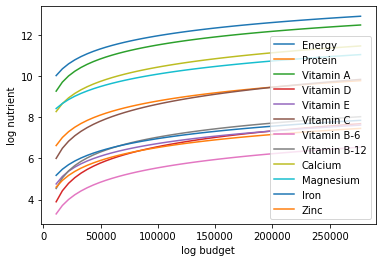

In [12]:
import numpy as np
import pandas as pd

### If you're getting lots of not useful warnings you want to ignore
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)
####################################################################

X = np.linspace(median_x/5,median_x*5,50)

# UseNutrients = ['Protein','Calories','Iron','Calcium']
UseNutrients = fct.columns.tolist()

plt.plot(X,pd.concat({x:np.log(nutrient_demand(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here we grab one such set of requirements:



In [13]:
rdi = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'

rdi = rdi.replace('',0)
rdi

k,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


#### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
    can&rsquo;t directly compare household level nutrition with individual
    level requirements.  What we **can** do is add up minimum individual
    requirements, and see whether household total exceed these.  This
    isn&rsquo;t a guarantee that all individuals have adequate nutrition
    (since the way food is allocated in the household might be quite
    unequal, or unrelated to individual requirements), but it is
    *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people
can be computed by averaging over households:



In [14]:
# Find average household characteristics for reference period & place
zbar = r.z.sel(t=my_t,m=my_m,drop=True).mean('j').to_dataframe()

Now, the inner/dot/matrix product between `zbar` and the `rda`
 DataFrame of requirements will give us minimum requirements for the
 average household:



In [15]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period:
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi

,z
n,
Energy,61856.695509
Protein,1397.929131
Fiber,865.993737
Folate,11654.841368
Calcium,37493.119077
Carbohydrate,4524.128554
Iron,378.484549
Magnesium,10063.473424
Niacin,443.881335


## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
 and we&rsquo;ve computed minimum nutritional requirements for the average
 household, we can *normalize* nutritional intake to check the adequacy
 of diet.



In [16]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

First, we wanted to look at all of the nutrients to see if there was any pattern or micronutrient that significantly stood out. 

In [17]:
UseNutrients = fct.columns.tolist()

In [18]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel(t=my_t,m=my_m).median('j') # Budget (median household)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

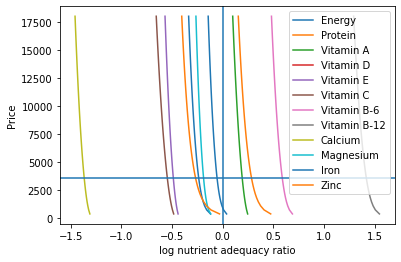

In [19]:
poorer_x = median_x/2

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=my_i).values)

The vertical lines of the graph shows the nutrient adqequacy ratio for all the nutrients in the FCT database. The further right the nutrient is located on the graph, the better. From observing the graph, we notice that calcium is significantly further to the left than the other nutrients. Additionally, a lot of the nutrients seem to clustered towards the negative side of the graph.

Based on the graph, let's take a closer look at the three nutrients that are furthest to the left: Calcium, Vitamin C, and Vitamin E. 

In [20]:
UseNutrients = ['Calcium', 'Vitamin C', 'Vitamin E']

In [21]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel(t=my_t,m=my_m).median('j') # Budget (median household)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

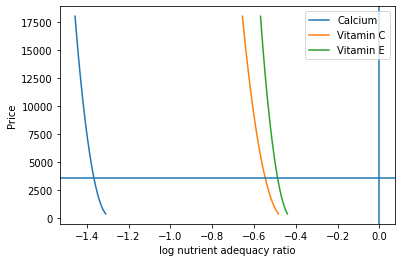

In [22]:
poorer_x = median_x/2

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=my_i).values)

/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

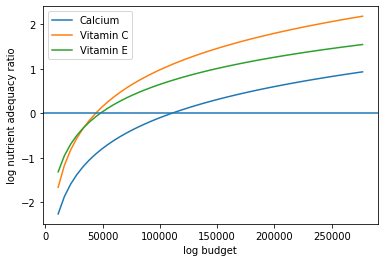

In [23]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

In [24]:
fct_nutrients = fct.iloc[0:, np.arange(4,11,6)]
fct_nutrients

n,Vitamin E,Iron
i,,
Beef,0,17
Bottled beer,0,0
Bread,0,5
Butter,30,1
Canned milk/milk powder,0,7
"Canned, dried and wild vegetables",0,23
Cassava dry/flour,0,19
Cassava fresh,2,3
Chicken,0,10


### Simple Policy Experiments



Consider two policies:  First, changing income so that some proportion
 of the population achieves nutritional adequacy.  Here choose quantile
 we&rsquo;re interested in (e.g., a quantile of 0.5 is the median; a quantile
 of 0.25 is the household at the 25th percentage point of the distribution).



In [31]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


### Compensated Policy Experiments



/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

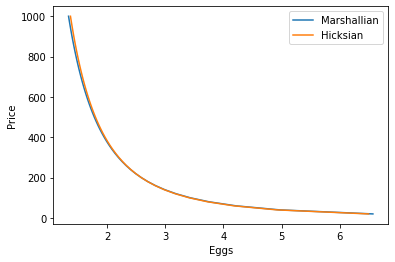

In [26]:
import matplotlib.pyplot as plt

my_i = 'Eggs'
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

U0 = r.indirect_utility(x0,p)

### If you're getting lots of not useful warnings you want to ignore
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)
####################################################################

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

In [27]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

Examine effects of price changes on *compensated* nutrient adequacy
(i.e., a price increase is accompanied by additional income to keep
utility constant).



/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

Text(0.5, 0, 'Price of Eggs')

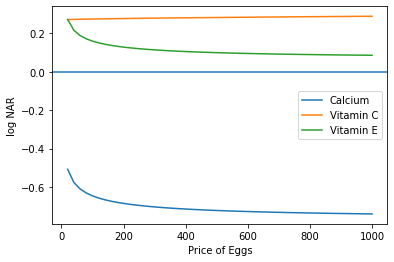

In [28]:
my_i = 'Eggs'

fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i)

Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.



/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

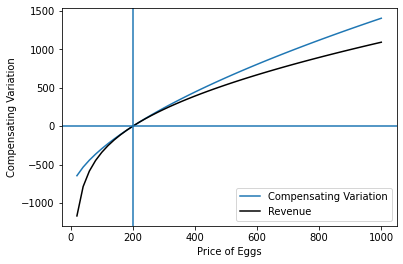

In [29]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])

Differences between revenue and compensating variation is deadweight-loss:



/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.8/site-packages/cfe/_utils.py:51: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative 

Text(0, 0.5, 'Deadweight Loss')

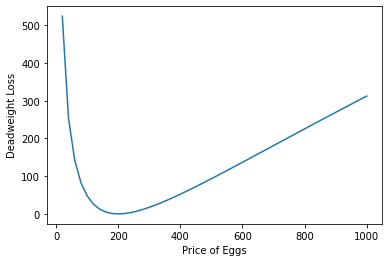

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")